## Setup and Data Loading

In [2]:
import os
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from tqdm import tqdm 
import pandas as pd
from sklearn.model_selection import KFold
from collections import Counter

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [4]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

torch version :  2.5.1+cu121
torchvision version :  0.20.1+cu121
numpy version :  1.26.4
matplotlib version :  3.7.5


## Exploring the dataset

In [5]:
train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

In [6]:
# check the diffenent classes of the dataset
classes = os.listdir(train_dir)
classes

['pituitary', 'notumor', 'meningioma', 'glioma']

In [7]:
def sample_images(data_path, classname):
    class_dir = os.path.join(data_path, classname)
    if not os.path.exists(class_dir):
        return "Invalid directory"
    image_list = os.listdir(class_dir)
    if len(image_list) < 4:
        return "Not enough images in folder"

    # Pick four random images
    images_sample = random.sample(image_list, 4)

    # Plot them
    plt.figure(figsize=(20, 20))
    for i in range(4):
        img_loc = os.path.join(class_dir, images_sample[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

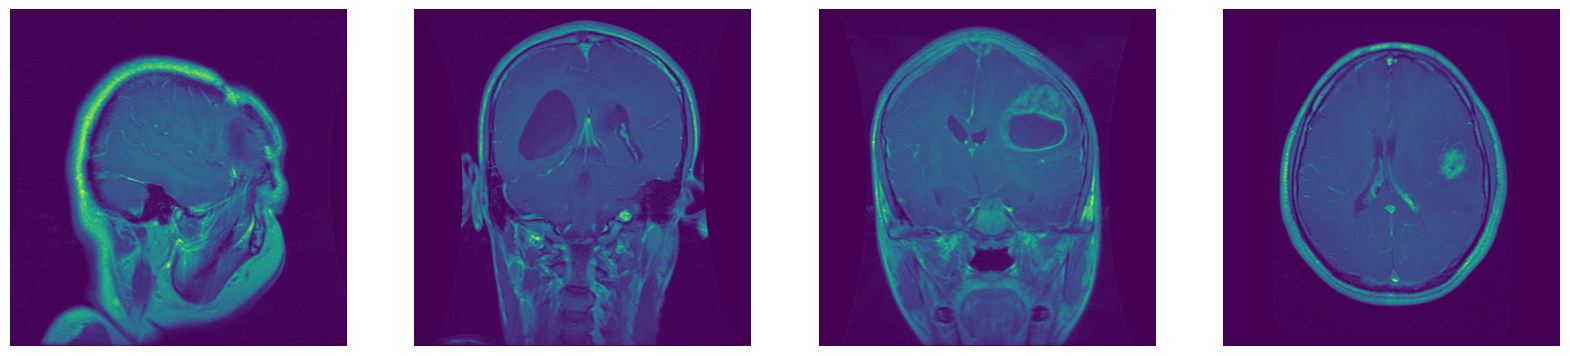

In [8]:
sample_images(train_dir, "glioma")

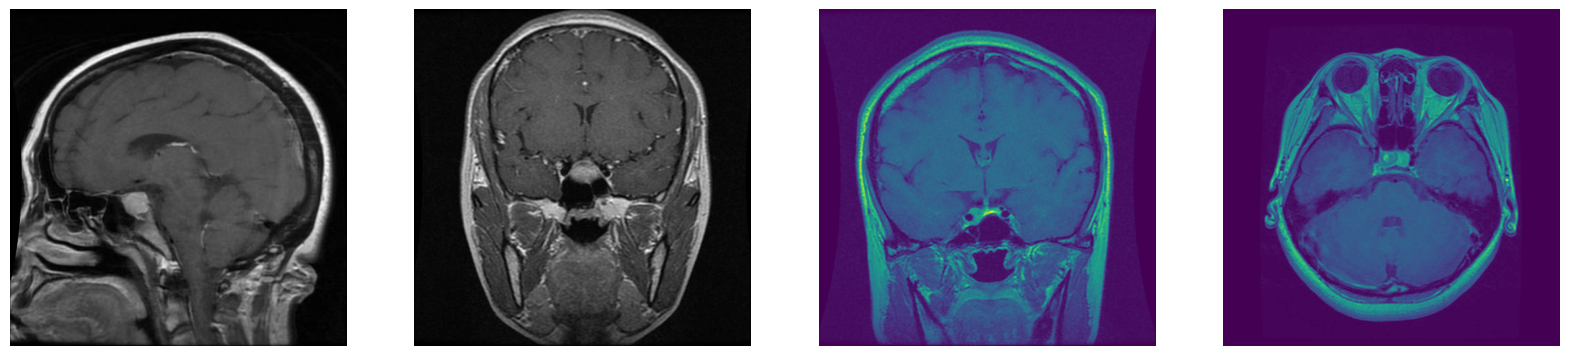

In [9]:
sample_images(train_dir, "pituitary")

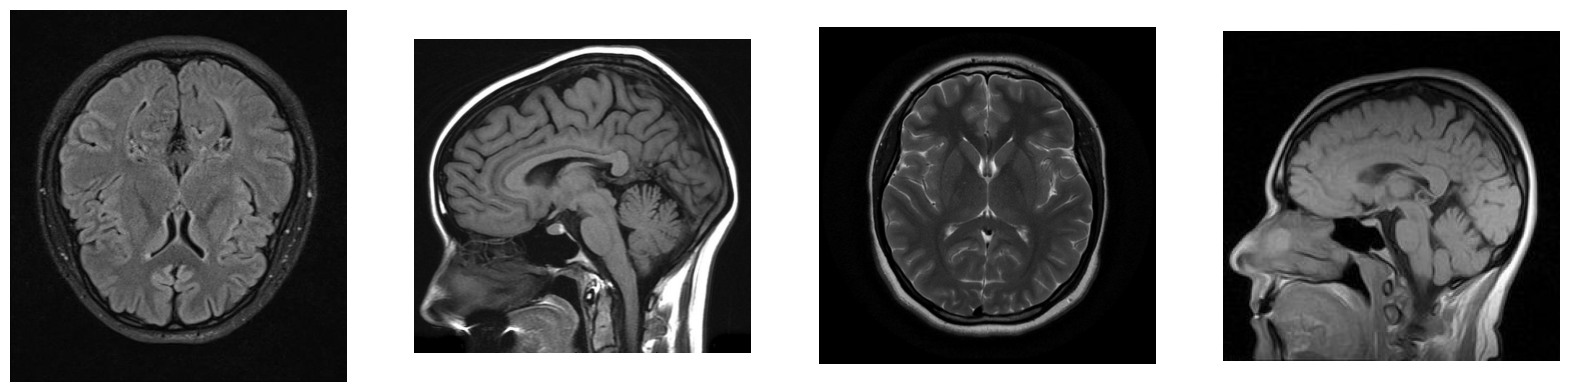

In [10]:
sample_images(train_dir, "notumor")

#### View the the number of image in each directory 

In [11]:
glioma_dir = os.path.join(train_dir,"glioma")
print(f"Number of glioma image: {len(os.listdir(glioma_dir))}")

Number of glioma image: 1321


In [12]:
meningioma_dir = os.path.join(train_dir,"meningioma")
print(f"Number of glioma image: {len(os.listdir(meningioma_dir))}")

Number of glioma image: 1339


In [13]:
notumor_dir = os.path.join(train_dir,"notumor")
print(f"Number of glioma image: {len(os.listdir(notumor_dir))}")

Number of glioma image: 1595


In [14]:
pituitary_dir = os.path.join(train_dir,"notumor")
print(f"Number of glioma image: {len(os.listdir(pituitary_dir))}")

Number of glioma image: 1595


#### Check the shape and number of channel in the image dataset

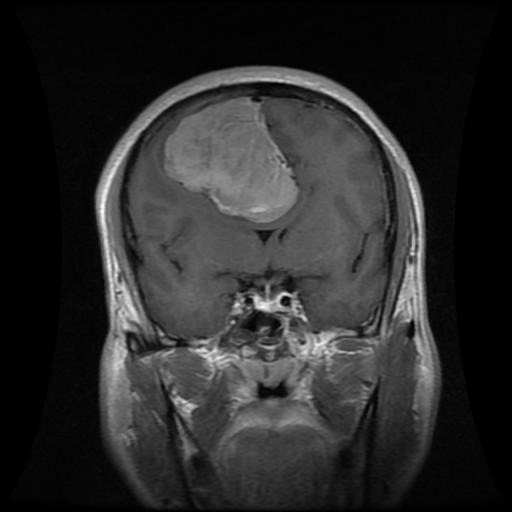

In [15]:
meningioma_sample = os.listdir(meningioma_dir)[0]
meningioma_sample_img = PIL.Image.open(os.path.join(meningioma_dir, meningioma_sample))
meningioma_sample_img

In [16]:
meningioma_sample_img.mode, meningioma_sample_img.size

('RGB', (512, 512))

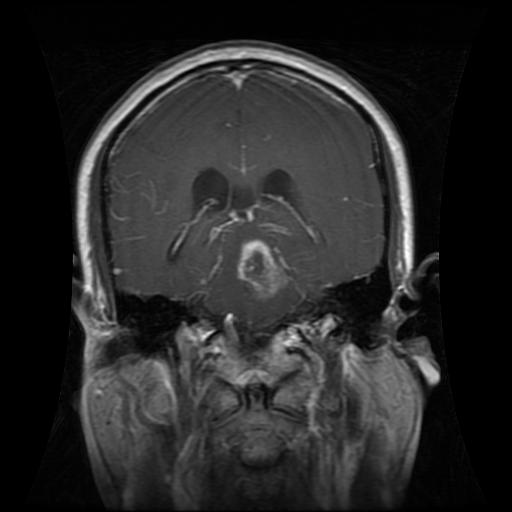

In [17]:
glioma_sample = os.listdir(glioma_dir)[1050]
glioma_sample_img = PIL.Image.open(os.path.join(glioma_dir, glioma_sample))
glioma_sample_img

In [18]:
glioma_sample_img.mode, glioma_sample_img.size

('L', (512, 512))

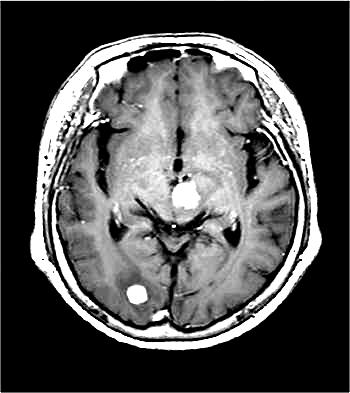

In [19]:
notumor_sample = os.listdir(notumor_dir)[1050]
notumor_sample_img = PIL.Image.open(os.path.join(notumor_dir, notumor_sample))
notumor_sample_img

In [20]:
notumor_sample_img.mode, notumor_sample_img.size

('RGB', (350, 393))

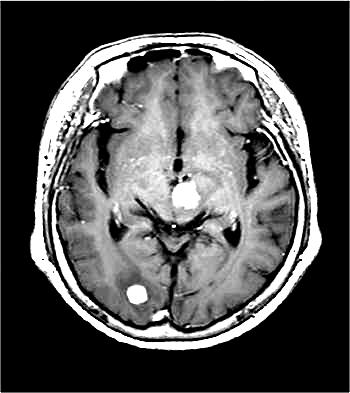

In [21]:
pituitary_sample = os.listdir(pituitary_dir)[1050]
pituitary_sample_img = PIL.Image.open(os.path.join(pituitary_dir, pituitary_sample))
pituitary_sample_img

In [22]:
pituitary_sample_img.mode, pituitary_sample_img.size

('RGB', (350, 393))

_The dataset does not have the same size and mode we have to convert them to the same channel and also to the same size_

In [23]:
class ConvertImage:
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert("RGB")
        return img    

### Normalize the dataset

In [24]:
transform_nonorm = transforms.Compose(
    [
        ConvertImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

batch_size=32

In [25]:
# load the dataset to get the mean and std  to use for normalization
dataset = datasets.ImageFolder(train_dir, transform=transform_nonorm)
loader = DataLoader(dataset, batch_size=batch_size)

In [26]:
def mean_std(loader):
    count, count_square, num_batches = 0,0, 0
    for data, _ in tqdm(loader):
        count += torch.mean(data, dim=[0, 2, 3])
        count_square += torch.mean(data ** 2, dim=[0,2,3])
        num_batches += 1
        
    mean = count / num_batches
    std = (count_square / num_batches - mean**2) ** 0.5
    
    return mean, std

In [27]:
mean, std = mean_std(loader)

100%|██████████| 179/179 [00:38<00:00,  4.69it/s]


In [28]:
mean, std

(tensor([0.1855, 0.1856, 0.1856]), tensor([0.2003, 0.2003, 0.2003]))

_We have not normalized the data so the mean is not 0 and std is not one_

In [29]:
transform = transforms.Compose(
    [
        ConvertImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

_we now have the normalized mean and std_

In [30]:
batch_size = 32
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [31]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

#### Visualize the distribution of the training and test dataset

100%|██████████| 5712/5712 [00:23<00:00, 245.82it/s]


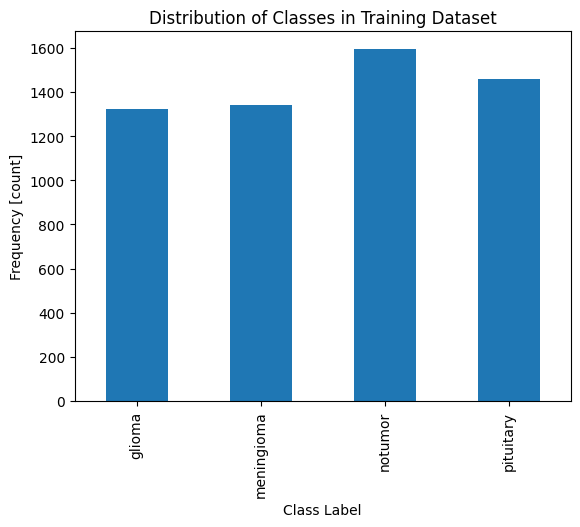

In [32]:
train_counts = class_counts(train_dataset)

train_counts.plot(kind="bar")
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset");

100%|██████████| 1311/1311 [00:08<00:00, 153.50it/s]


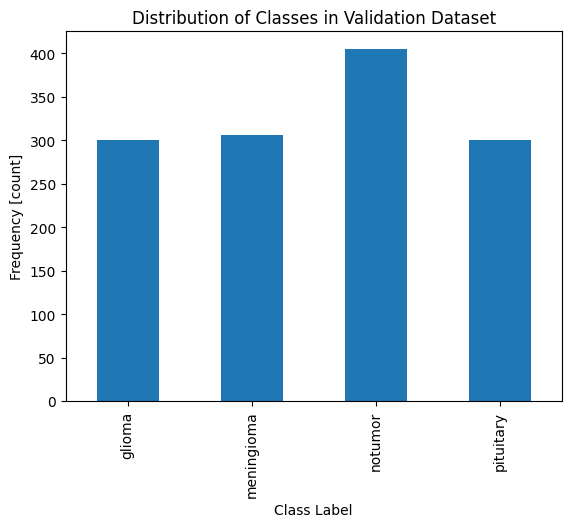

In [33]:
val_counts = class_counts(test_dataset)

val_counts.plot(kind="bar")
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset");

In [34]:
# create dataloader
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Building a CNN Network for the classification using pretrained model and from scratch CNN model
_I would try out 2 different pretrained model, Densenet and Resnet the choose to tune the one which give the best basic performance for parameter tuning I would also train a new CNN using new weights_

In [35]:
desnet = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 153MB/s] 


In [36]:
resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s] 


In [37]:
for params in resnet.parameters():
    params.requires_grad = False
    
for params in desnet.parameters():
    params.requires_grad = False

In [38]:
#  move the models to device
resnet.to(device)
desnet.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [39]:
# get the name of the last layer of the pretrained network
print(list(resnet.named_modules())[-1])
print(list(desnet.named_modules())[-1])

('fc', Linear(in_features=2048, out_features=1000, bias=True))
('classifier', Linear(in_features=1024, out_features=1000, bias=True))


In [40]:
# get the number of input feature of the last layer
print(resnet.fc.in_features)
print(desnet.classifier.in_features)

2048
1024


In [41]:
classifier_resnet = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(in_features=512, out_features=4)
)

classifier_desnet = torch.nn.Sequential(
    torch.nn.Linear(in_features=1024, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(in_features=512, out_features=4)
)

In [42]:
resnet.fc = classifier_resnet
desnet.classifier = classifier_desnet

In [43]:
# define optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer_res = optim.Adam(resnet.parameters())
optimizer_des = optim.Adam(desnet.parameters())

In [44]:
# get the name given to each submodule
resnet.fc

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)

In [45]:
# get the names of the submodule
desnet.classifier

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)

_I am going to be using cross-validation to train the model, to get an accurate values, I need to reset the model for each folds_

In [46]:
def reset_classifier(model):
    """
    Resets the parameters of the classifier layer for both ResNet and DenseNet models.
    
    Args:
        model: The model whose classifier parameters are to be reset. 
               Supports torchvision's ResNet and DenseNet architectures.
    """
    if hasattr(model, "fc"):  # For ResNet
        classifier = model.fc
    elif hasattr(model, "classifier"):  # For DenseNet
        classifier = model.classifier
    else:
        raise ValueError("The provided model does not have a recognizable classifier attribute.")
    
    # Reset the parameters of the classifier submodules
    for submodule in ["0", "3"]:
        if submodule in classifier._modules:  
            classifier.get_submodule(submodule).reset_parameters()


### Define the functions for training and evaluating the models

In [47]:
def train_model(dataloader, device, optimizer, loss_fn, model):
    
    model.train()
    training_loss = 0.0
    for data, label in tqdm(dataloader):
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = loss_fn(output, label)
        
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item() * data.size(0)
        
    return training_loss / len(dataloader.dataset)

In [48]:
def predict(model, dataloader, device):
    model.eval()
    prob = torch.tensor([]).to(device)
    
    with torch.no_grad():
        for data, label in tqdm(dataloader):
            data = data.to(device)
            output = model(data)
            out_prob = nn.functional.softmax(output, dim=1)
            
            prob = torch.cat((prob, out_prob), dim=0)
    return prob

In [49]:
def loss_accuracy(model, dataloader, loss_fn, device):
    total_loss = 0
    total_correct = 0

    model.to(device)
    model.eval()
    with torch.no_grad():
        for data, label in tqdm(dataloader):
            data = data.to(device)
            output = model(data)
            
            label = label.to(device)
            loss = loss_fn(output, label)
            total_loss += loss.data.item() * data.size(0)
            
            correct = torch.eq(torch.argmax(output, dim=1), label)
            total_correct += torch.sum(correct).item()
            
    n_observations = dataloader.batch_size * len(dataloader)
    accuracy = total_correct / n_observations
    average_loss = total_loss / n_observations
    
    return average_loss, accuracy

### Codes for the model callbacks

In [50]:
# learning rate scheduler
step_size = 3
gamma = 0.1

# Initialize the learning rate scheduler
scheduler_res = StepLR(
    optimizer_res,
    step_size=step_size,
    gamma=gamma,
)

scheduler_des = StepLR(
    optimizer_des,
    step_size=step_size,
    gamma=gamma,
)

In [51]:
def early_stopping(validation_loss, best_val_loss, counter):
    """Function that implements Early Stopping"""

    stop = False

    if validation_loss < best_val_loss:
        counter = 0
    else:
        counter += 1

    if counter >= 5:
        step = True

    return counter, stop

In [52]:
def checkpointing(validation_loss, best_val_loss, model, optimizer, save_path):
    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": validation_loss,
            },
            save_path,
        )

In [53]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    # Create the trackers if needed for checkpointing and early stopping
    best_val_loss = float("inf")
    early_stopping_counter = 0

    print("Model evaluation before start of training...")
    # Test on training set
    train_loss, train_accuracy = loss_accuracy(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Test on validation set
    validation_loss, validation_accuracy = loss_accuracy(model, val_loader, loss_fn, device)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")

        # Train one epoch
        train_model(train_loader, device, optimizer, loss_fn, model)

        # Evaluate training results
        train_loss, train_accuracy = loss_accuracy(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = loss_accuracy(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.4f}%")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation accuracy: {validation_accuracy*100:.4f}%")

        # # Log the learning rate and have the scheduler adjust it
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()

        # Checkpointing saves the model if current model is better than best so far
        if checkpoint_path:
            checkpointing(
                validation_loss, best_val_loss, model, optimizer, checkpoint_path
            )

        # Early Stopping
        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                validation_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss

    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )

### Training for resnet

In [54]:
epochs_to_train = 20

train_results = train(
    resnet,
    optimizer_res,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler_res,
    checkpoint_path="res_model.pth",
    early_stopping=early_stopping,
)

(
    learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
) = train_results

Model evaluation before start of training...


100%|██████████| 41/41 [00:08<00:00,  4.64it/s]




Starting epoch 1/20


100%|██████████| 41/41 [00:08<00:00,  4.80it/s]


Epoch: 1
Training loss: 0.2709
Training accuracy: 91.2186%
Validation loss: 0.3738
Validation accuracy: 87.1951%


Starting epoch 2/20


100%|██████████| 41/41 [00:08<00:00,  4.69it/s]


Epoch: 2
Training loss: 0.2661
Training accuracy: 91.4979%
Validation loss: 0.4751
Validation accuracy: 86.3567%


Starting epoch 3/20


100%|██████████| 41/41 [00:08<00:00,  4.63it/s]


Epoch: 3
Training loss: 0.4962
Training accuracy: 94.7975%
Validation loss: 1.6928
Validation accuracy: 90.2439%


Starting epoch 4/20


100%|██████████| 41/41 [00:08<00:00,  4.62it/s]


Epoch: 4
Training loss: 0.1239
Training accuracy: 95.6355%
Validation loss: 0.2318
Validation accuracy: 91.1585%


Starting epoch 5/20


100%|██████████| 41/41 [00:08<00:00,  4.70it/s]


Epoch: 5
Training loss: 0.1710
Training accuracy: 95.1990%
Validation loss: 0.2976
Validation accuracy: 90.1677%


Starting epoch 6/20


100%|██████████| 41/41 [00:08<00:00,  4.57it/s]


Epoch: 6
Training loss: 0.1199
Training accuracy: 96.0894%
Validation loss: 0.2584
Validation accuracy: 91.4634%


Starting epoch 7/20


100%|██████████| 41/41 [00:08<00:00,  4.56it/s]


Epoch: 7
Training loss: 0.1232
Training accuracy: 95.7402%
Validation loss: 0.2414
Validation accuracy: 91.1585%


Starting epoch 8/20


100%|██████████| 41/41 [00:09<00:00,  4.53it/s]


Epoch: 8
Training loss: 0.1372
Training accuracy: 95.7228%
Validation loss: 0.2492
Validation accuracy: 91.0823%


Starting epoch 9/20


100%|██████████| 41/41 [00:08<00:00,  4.61it/s]


Epoch: 9
Training loss: 0.2720
Training accuracy: 94.7277%
Validation loss: 0.6301
Validation accuracy: 90.2439%


Starting epoch 10/20


100%|██████████| 41/41 [00:09<00:00,  4.36it/s]


Epoch: 10
Training loss: 0.1171
Training accuracy: 95.8450%
Validation loss: 0.2392
Validation accuracy: 91.3872%


Starting epoch 11/20


100%|██████████| 41/41 [00:08<00:00,  4.72it/s]


Epoch: 11
Training loss: 0.1673
Training accuracy: 95.9323%
Validation loss: 0.4105
Validation accuracy: 91.6159%


Starting epoch 12/20


100%|██████████| 41/41 [00:08<00:00,  4.57it/s]


Epoch: 12
Training loss: 0.1598
Training accuracy: 95.9323%
Validation loss: 0.3270
Validation accuracy: 91.4634%


Starting epoch 13/20


100%|██████████| 41/41 [00:08<00:00,  4.67it/s]


Epoch: 13
Training loss: 0.1758
Training accuracy: 94.9895%
Validation loss: 0.3215
Validation accuracy: 90.3963%


Starting epoch 14/20


100%|██████████| 41/41 [00:08<00:00,  4.56it/s]


Epoch: 14
Training loss: 0.2122
Training accuracy: 94.8499%
Validation loss: 0.4340
Validation accuracy: 90.3963%


Starting epoch 15/20


100%|██████████| 41/41 [00:08<00:00,  4.66it/s]


Epoch: 15
Training loss: 0.2324
Training accuracy: 94.0468%
Validation loss: 0.4071
Validation accuracy: 89.1006%


Starting epoch 16/20


100%|██████████| 41/41 [00:08<00:00,  4.57it/s]


Epoch: 16
Training loss: 0.1788
Training accuracy: 94.3959%
Validation loss: 0.3075
Validation accuracy: 90.0915%


Starting epoch 17/20


100%|██████████| 41/41 [00:09<00:00,  4.54it/s]


Epoch: 17
Training loss: 0.2512
Training accuracy: 94.5007%
Validation loss: 0.5839
Validation accuracy: 89.9390%


Starting epoch 18/20


100%|██████████| 41/41 [00:09<00:00,  4.53it/s]


Epoch: 18
Training loss: 0.2914
Training accuracy: 94.7277%
Validation loss: 0.7523
Validation accuracy: 90.3963%


Starting epoch 19/20


100%|██████████| 41/41 [00:08<00:00,  4.64it/s]


Epoch: 19
Training loss: 0.1754
Training accuracy: 94.2912%
Validation loss: 0.2885
Validation accuracy: 90.0915%


Starting epoch 20/20


100%|██████████| 41/41 [00:08<00:00,  4.59it/s]

Epoch: 20
Training loss: 0.2250
Training accuracy: 95.9323%
Validation loss: 0.4417
Validation accuracy: 91.7683%


In [69]:
data = {
    'train_loss': train_losses,
    'valid_loss': valid_losses,
    'train_accuracy': train_accuracies,
    'valid_accuracy': valid_accuracies,
    'epoch': epochs
}

# Create the DataFrame
resnet = pd.DataFrame(data)

In [70]:
resnet.to_csv("resnet.csv")

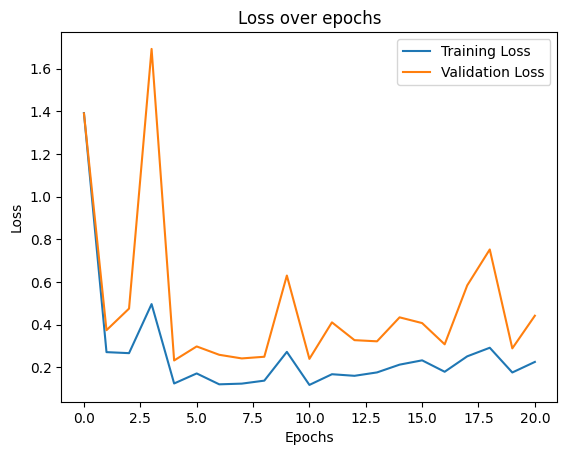

In [71]:
plt.plot(resnet.train_loss, label="Training Loss")
plt.plot(resnet.valid_loss, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

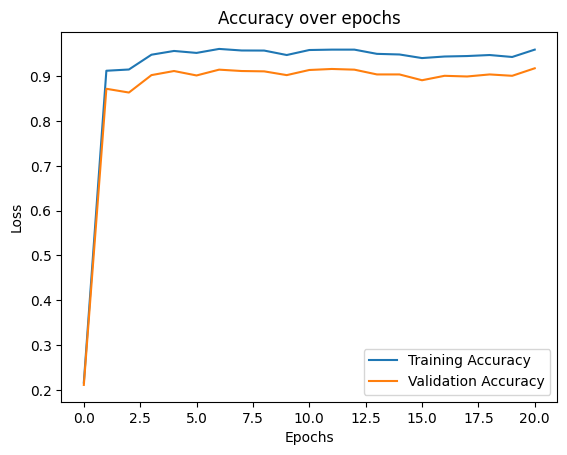

In [72]:
plt.plot(resnet.train_accuracy, label="Training Accuracy")
plt.plot(resnet.valid_accuracy, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

### Training for desnet

In [55]:
epochs_to_train = 20

train_results = train(
    desnet,
    optimizer_des,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler_des,
    checkpoint_path="des_model.pth",
    early_stopping=early_stopping,
)

(
    learning_rates_des,
    train_losses_des,
    valid_losses_des,
    train_accuracies_des,
    valid_accuracies_des,
    epochs,
) = train_results

Model evaluation before start of training...


100%|██████████| 41/41 [00:09<00:00,  4.42it/s]




Starting epoch 1/20


100%|██████████| 41/41 [00:09<00:00,  4.46it/s]


Epoch: 1
Training loss: 0.2673
Training accuracy: 89.8568%
Validation loss: 0.3548
Validation accuracy: 85.8994%


Starting epoch 2/20


100%|██████████| 41/41 [00:09<00:00,  4.47it/s]


Epoch: 2
Training loss: 0.2453
Training accuracy: 90.9742%
Validation loss: 0.3391
Validation accuracy: 86.5854%


Starting epoch 3/20


100%|██████████| 41/41 [00:09<00:00,  4.49it/s]


Epoch: 3
Training loss: 0.2079
Training accuracy: 91.7772%
Validation loss: 0.3066
Validation accuracy: 88.1860%


Starting epoch 4/20


100%|██████████| 41/41 [00:09<00:00,  4.51it/s]


Epoch: 4
Training loss: 0.1782
Training accuracy: 93.3485%
Validation loss: 0.2687
Validation accuracy: 89.2530%


Starting epoch 5/20


100%|██████████| 41/41 [00:09<00:00,  4.52it/s]


Epoch: 5
Training loss: 0.1714
Training accuracy: 93.4532%
Validation loss: 0.2563
Validation accuracy: 90.3201%


Starting epoch 6/20


100%|██████████| 41/41 [00:09<00:00,  4.45it/s]


Epoch: 6
Training loss: 0.1688
Training accuracy: 93.7500%
Validation loss: 0.2461
Validation accuracy: 90.9299%


Starting epoch 7/20


100%|██████████| 41/41 [00:09<00:00,  4.47it/s]


Epoch: 7
Training loss: 0.1692
Training accuracy: 93.5580%
Validation loss: 0.2557
Validation accuracy: 90.0152%


Starting epoch 8/20


100%|██████████| 41/41 [00:09<00:00,  4.47it/s]


Epoch: 8
Training loss: 0.1635
Training accuracy: 93.7675%
Validation loss: 0.2422
Validation accuracy: 90.7774%


Starting epoch 9/20


100%|██████████| 41/41 [00:09<00:00,  4.44it/s]


Epoch: 9
Training loss: 0.1653
Training accuracy: 93.6627%
Validation loss: 0.2481
Validation accuracy: 89.8628%


Starting epoch 10/20


100%|██████████| 41/41 [00:09<00:00,  4.43it/s]


Epoch: 10
Training loss: 0.1700
Training accuracy: 93.5580%
Validation loss: 0.2572
Validation accuracy: 90.1677%


Starting epoch 11/20


100%|██████████| 41/41 [00:09<00:00,  4.52it/s]


Epoch: 11
Training loss: 0.1668
Training accuracy: 93.7675%
Validation loss: 0.2512
Validation accuracy: 89.9390%


Starting epoch 12/20


100%|██████████| 41/41 [00:09<00:00,  4.55it/s]


Epoch: 12
Training loss: 0.1626
Training accuracy: 93.7151%
Validation loss: 0.2393
Validation accuracy: 90.2439%


Starting epoch 13/20


100%|██████████| 41/41 [00:09<00:00,  4.46it/s]


Epoch: 13
Training loss: 0.1730
Training accuracy: 93.2263%
Validation loss: 0.2630
Validation accuracy: 89.4055%


Starting epoch 14/20


100%|██████████| 41/41 [00:09<00:00,  4.50it/s]


Epoch: 14
Training loss: 0.1677
Training accuracy: 93.7500%
Validation loss: 0.2561
Validation accuracy: 89.7104%


Starting epoch 15/20


100%|██████████| 41/41 [00:08<00:00,  4.58it/s]


Epoch: 15
Training loss: 0.1641
Training accuracy: 93.7325%
Validation loss: 0.2462
Validation accuracy: 90.0152%


Starting epoch 16/20


100%|██████████| 41/41 [00:09<00:00,  4.34it/s]


Epoch: 16
Training loss: 0.1667
Training accuracy: 93.6627%
Validation loss: 0.2502
Validation accuracy: 90.0152%


Starting epoch 17/20


100%|██████████| 41/41 [00:09<00:00,  4.55it/s]


Epoch: 17
Training loss: 0.1687
Training accuracy: 93.5230%
Validation loss: 0.2550
Validation accuracy: 89.9390%


Starting epoch 18/20


100%|██████████| 41/41 [00:09<00:00,  4.48it/s]


Epoch: 18
Training loss: 0.1639
Training accuracy: 93.8897%
Validation loss: 0.2432
Validation accuracy: 90.5488%


Starting epoch 19/20


100%|██████████| 41/41 [00:09<00:00,  4.47it/s]


Epoch: 19
Training loss: 0.1651
Training accuracy: 93.7675%
Validation loss: 0.2511
Validation accuracy: 90.1677%


Starting epoch 20/20


100%|██████████| 41/41 [00:09<00:00,  4.41it/s]

Epoch: 20
Training loss: 0.1644
Training accuracy: 93.9770%
Validation loss: 0.2499
Validation accuracy: 90.3201%


### Check the model performance

In [68]:
data = {
    'train_loss': train_losses_des,
    'valid_loss': valid_losses_des,
    'train_accuracy': train_accuracies_des,
    'valid_accuracy': valid_accuracies_des,
    'epoch': epochs
}

# Create the DataFrame
desnet = pd.DataFrame(data)

In [57]:
desnet.head()

,train_loss,valid_loss,train_accuracy,valid_accuracy,epoch
0,1.379332,1.373403,0.274965,0.300305,20
1,0.267273,0.354800,0.898568,0.858994,20
2,0.245293,0.339070,0.909742,0.865854,20
3,0.207883,0.306600,0.917772,0.881860,20
4,0.178153,0.268742,0.933485,0.892530,20


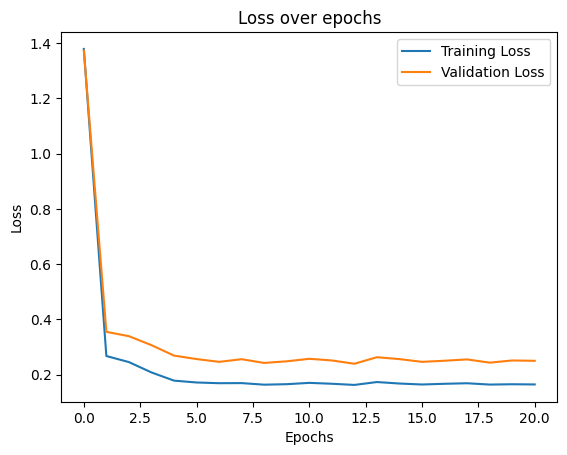

In [58]:
plt.plot(desnet.train_loss, label="Training Loss")
plt.plot(desnet.valid_loss, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

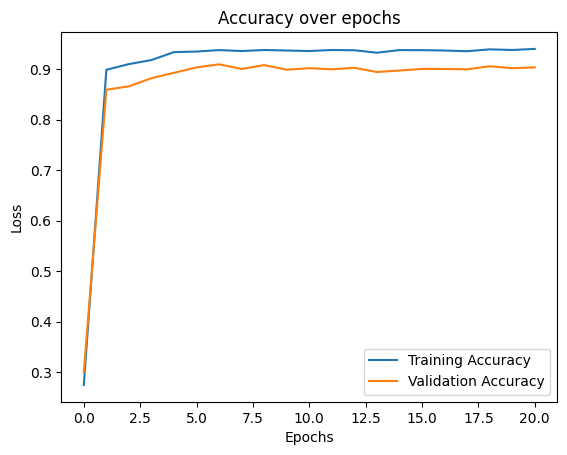

In [59]:
plt.plot(desnet.train_accuracy, label="Training Accuracy")
plt.plot(desnet.valid_accuracy, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [60]:
# save the metric dataframe
desnet.to_csv("desnet.csv")

### Build a custom model

In [61]:
import torch.nn as nn

model = nn.Sequential(
    # Convolutional Layer 1
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    # Convolutional Layer 2
    nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    # Convolutional Layer 3
    nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    # Flatten Layer
    nn.Flatten(),
    # Fully Connected Layers
    nn.Linear(in_features=16 * 28 * 28, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=4)
)

# Model summary
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=12544, out_features=64, bias=True)
  (11): ReLU()
  (12): Linear(in_features=64, out_features=32, bias=True)
  (13): ReLU()
  (14): Linear(in_features=32, out_features=4, bias=True)
)


In [62]:
# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler (StepLR, decreases LR every 10 epochs)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [63]:
epochs_to_train = 20

train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="self_model.pth",
    early_stopping=early_stopping,
)

(
    learning_rates_self,
    train_losses_self,
    valid_losses_self,
    train_accuracies_self,
    valid_accuracies_self,
    epochs,
) = train_results

Model evaluation before start of training...


100%|██████████| 41/41 [00:06<00:00,  6.79it/s]




Starting epoch 1/20


100%|██████████| 41/41 [00:06<00:00,  6.77it/s]


Epoch: 1
Training loss: 0.4746
Training accuracy: 79.6089%
Validation loss: 0.5509
Validation accuracy: 77.5152%


Starting epoch 2/20


100%|██████████| 41/41 [00:06<00:00,  6.72it/s]


Epoch: 2
Training loss: 0.2516
Training accuracy: 89.2458%
Validation loss: 0.3882
Validation accuracy: 82.3171%


Starting epoch 3/20


100%|██████████| 41/41 [00:06<00:00,  6.62it/s]


Epoch: 3
Training loss: 0.1491
Training accuracy: 94.7626%
Validation loss: 0.2652
Validation accuracy: 89.9390%


Starting epoch 4/20


100%|██████████| 41/41 [00:05<00:00,  7.00it/s]


Epoch: 4
Training loss: 0.0900
Training accuracy: 96.9274%
Validation loss: 0.2193
Validation accuracy: 92.1494%


Starting epoch 5/20


100%|██████████| 41/41 [00:09<00:00,  4.53it/s]


Epoch: 5
Training loss: 0.0950
Training accuracy: 96.0021%
Validation loss: 0.2622
Validation accuracy: 91.6159%


Starting epoch 6/20


100%|██████████| 41/41 [00:06<00:00,  6.57it/s]


Epoch: 6
Training loss: 0.0651
Training accuracy: 97.5209%
Validation loss: 0.3200
Validation accuracy: 91.9207%


Starting epoch 7/20


100%|██████████| 41/41 [00:06<00:00,  6.78it/s]


Epoch: 7
Training loss: 0.0272
Training accuracy: 98.9001%
Validation loss: 0.1469
Validation accuracy: 95.4268%


Starting epoch 8/20


100%|██████████| 41/41 [00:06<00:00,  6.67it/s]


Epoch: 8
Training loss: 0.0460
Training accuracy: 98.3589%
Validation loss: 0.2548
Validation accuracy: 93.5976%


Starting epoch 9/20


100%|██████████| 41/41 [00:06<00:00,  6.78it/s]


Epoch: 9
Training loss: 0.0077
Training accuracy: 99.4588%
Validation loss: 0.2301
Validation accuracy: 94.5884%


Starting epoch 10/20


100%|██████████| 41/41 [00:06<00:00,  6.58it/s]


Epoch: 10
Training loss: 0.0124
Training accuracy: 99.3366%
Validation loss: 0.2304
Validation accuracy: 94.7409%


Starting epoch 11/20


100%|██████████| 41/41 [00:06<00:00,  6.79it/s]


Epoch: 11
Training loss: 0.0032
Training accuracy: 99.6508%
Validation loss: 0.1899
Validation accuracy: 95.8079%


Starting epoch 12/20


100%|██████████| 41/41 [00:06<00:00,  6.49it/s]


Epoch: 12
Training loss: 0.0021
Training accuracy: 99.6858%
Validation loss: 0.1993
Validation accuracy: 95.8079%


Starting epoch 13/20


100%|██████████| 41/41 [00:06<00:00,  6.61it/s]


Epoch: 13
Training loss: 0.0017
Training accuracy: 99.6858%
Validation loss: 0.2059
Validation accuracy: 95.4268%


Starting epoch 14/20


100%|██████████| 41/41 [00:05<00:00,  6.90it/s]


Epoch: 14
Training loss: 0.0013
Training accuracy: 99.7032%
Validation loss: 0.2084
Validation accuracy: 95.7317%


Starting epoch 15/20


100%|██████████| 41/41 [00:06<00:00,  6.49it/s]


Epoch: 15
Training loss: 0.0010
Training accuracy: 99.7032%
Validation loss: 0.2128
Validation accuracy: 95.7317%


Starting epoch 16/20


100%|██████████| 41/41 [00:06<00:00,  6.40it/s]


Epoch: 16
Training loss: 0.0008
Training accuracy: 99.7032%
Validation loss: 0.2168
Validation accuracy: 95.7317%


Starting epoch 17/20


100%|██████████| 41/41 [00:05<00:00,  6.85it/s]


Epoch: 17
Training loss: 0.0008
Training accuracy: 99.7207%
Validation loss: 0.2215
Validation accuracy: 95.5030%


Starting epoch 18/20


100%|██████████| 41/41 [00:05<00:00,  6.85it/s]


Epoch: 18
Training loss: 0.0005
Training accuracy: 99.7207%
Validation loss: 0.2251
Validation accuracy: 95.7317%


Starting epoch 19/20


100%|██████████| 41/41 [00:05<00:00,  6.87it/s]


Epoch: 19
Training loss: 0.0004
Training accuracy: 99.7207%
Validation loss: 0.2289
Validation accuracy: 95.7317%


Starting epoch 20/20


100%|██████████| 41/41 [00:06<00:00,  6.19it/s]

Epoch: 20
Training loss: 0.0004
Training accuracy: 99.7207%
Validation loss: 0.2324
Validation accuracy: 95.8079%


In [64]:
data_self = {
    'train_loss': train_losses_self,
    'valid_loss': valid_losses_self,
    'train_accuracy': train_accuracies_self,
    'valid_accuracy': valid_accuracies_self,
    'epoch': epochs
}

# Create the DataFrame
self = pd.DataFrame(data)

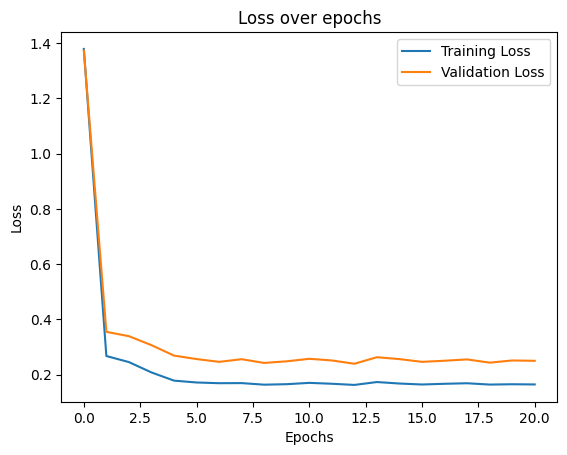

In [65]:
plt.plot(self.train_loss, label="Training Loss")
plt.plot(self.valid_loss, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

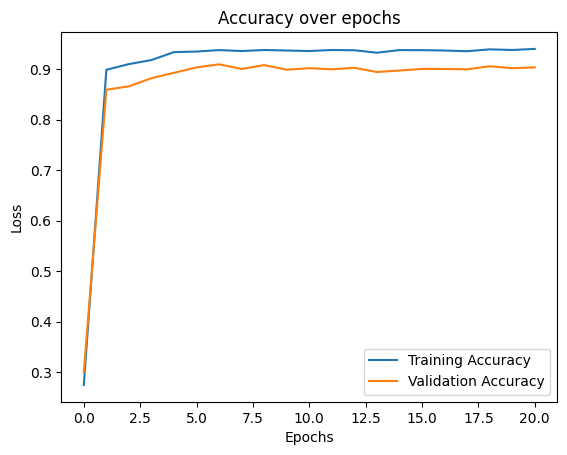

In [66]:
plt.plot(self.train_accuracy, label="Training Accuracy")
plt.plot(self.valid_accuracy, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [67]:
self.to_csv("self.csv")

### Load the best model

_the best model we have so far is the cnn model we built from scratch lets improve the model further_

In [85]:
model = nn.Sequential(
    # Convolutional Layer 1
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),  # (224, 224)
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),


    # Convolutional Layer 2
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),  # (112, 112)
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2), 
 

    # Convolutional Layer 3
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding=1), 
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2), 
 

    # Additional Convolutional Layer
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=1, padding=1), 
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),

    # Flatten Layer
    nn.Flatten(),

    # Fully Connected Layers
    nn.Linear(in_features=512 * 14 * 14, out_features=1024), 
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=4) 
)

# Print the model architecture to verify
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(k

In [86]:
# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler (StepLR, decreases LR every 10 epochs)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [178]:
epochs_to_train = 20

train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="final_model.pth",
    early_stopping=early_stopping,
)

(
    learning_rates_self,
    train_losses_self,
    valid_losses_self,
    train_accuracies_self,
    valid_accuracies_self,
    epochs,
) = train_results

In [ ]:
model = nn.Sequential(
    # Convolutional Layer 1
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),  # (224, 224)
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),  # (112, 112)
    nn.Dropout(0.25),
    # Convolutional Layer 2
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),  # (112, 112)
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),  # (56, 56)
    nn.Dropout(0.25),

    # Flatten Layer
    nn.Flatten(),

    # Fully Connected Layers
    nn.Linear(in_features=64 * 56 * 56, out_features=512),  # Corrected in_features
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=512, out_features=128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=128, out_features=4)  # 4 output classes
)



In [ ]:
# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler (StepLR, decreases LR every 10 epochs)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
epochs_to_train = 20

train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="final_model.pth",
    early_stopping=early_stopping,
)

(
    learning_rates_self,
    train_losses_self,
    valid_losses_self,
    train_accuracies_self,
    valid_accuracies_self,
    epochs,
) = train_results

_the last two model did not give a better result i would sitck with the first one_